In [59]:
# Import the required dependendecies
from utils.utils import *

plt.rcParams['figure.figsize'] = [18, 10] # Set the default image size for graph

For this spike code let us assume user wants to search for services between ***Bournville***  and ***Reading***, with departure from Bournville at 8:00 AM. For simplicity we assume only single journey for one adult



In [60]:
startLocation = "BRV" # Bournvile
endLocation = "RDG" # Reading
startTime = "08:00" # Journey Start Time

```searchServices``` below is a subroutine to search services between given two station and given departure time. This is a simulation of what an actual API call would be. For this spike it is returning a list of 5 services with following fields

1. Fares in pence
2. Departure Time 
3. Arrival Time at final destination
4. List of calling stations

In [61]:
def searchServices(startLocation,endLocation,startTime):
    services = [
        [5720,"07:59","10:09",["BRV","SLY","UNI","FWY","BHM","LMS","BAN","OXF","RDG"]],
        [6015,"08:39","10:41",["BRV","SLY","UNI","FWY","BHM","BHI","COV","LMS","BAN","OXF","RDG"]],
        [2995,"08:59","11:10",["BRV","SLY","UNI","FWY","BHM","LMS","BAN","OXF","RDG"]],
        [2995,"09:39","11:41",["BRV","SLY","UNI","FWY","BHM","BHI","COV","LMS","BAN","OXF","RDG"]],
        [2995,"09:59","12:06",["BRV","SLY","UNI","FWY","BHM","LMS","BAN","OXF","RDG"]]
    ]
    
    return services

In [62]:
# Invoke Search Services
services = searchServices(startLocation,endLocation,startTime)
print(services[0][3])

['BRV', 'SLY', 'UNI', 'FWY', 'BHM', 'LMS', 'BAN', 'OXF', 'RDG']


From above you can see the calling points for 7:59 service to Reading are

1. Selly Oak
2. University 
3. Five Ways
4. Birmingham New Street
5. Leamington Spa
6. Banbury 
7. Oxford 

In [63]:
stopsFromAllServices = [y for x in services for y in x[3]]
len(unique_list(stopsFromAllServices))


11

There are 11 unique calling points based on the above 5 services returned. To reduce the complexity of split ticketing process, lets find calling points which are 30% common in all services.

In [64]:
commonStopPointPercent = 30
noOfOccurance = math.floor((commonStopPointPercent/100)*(len(unique_list(stopsFromAllServices))))
commonStoppingList = filter(lambda i: check_list(stopsFromAllServices,i,noOfOccurance), stopsFromAllServices)
commonStoppingList =unique_list(commonStoppingList)
commonStoppingList
 

['BRV', 'SLY', 'UNI', 'FWY', 'BHM', 'LMS', 'BAN', 'OXF', 'RDG']

Above are services which are 30% common amongst all services

```stoppingPointsFare``` below is a subroutine which returns a matrix of fares  between our stopping points.  This is how it is read.

- First row denotes the fares of all calling points from Bournville.  
  - First row first column is fare between BRV and SLY
  - First row second column is fare between BRV and UNI
  - First row third column is fare between BRV and FWY 
  - and so on
- Second row denotes the fares of all calling points from SLY
  - Second row first column is fare between SLY and UNI
  - Second row second column is fare between SLY and FWY
  - and so on
- Similarly for other calling points

For simplicity lets take first service and lets try if we can get a cheaper fare by splitting ticket into parts

**Please note these are real fares as found here http://www.redspottedhanky.com/**

In [65]:
def stoppingPointsFare():
    fares = [
        [240,280,280,280,1275,1980,4130],
        [240,250,260,1275,1980,4130,6080],
        [240,260,1275,1980,4130,6080],
        [240,1235,1980,4130,6080],
        [750,1420,4130,6080],
        [850,2000,4730],
        [670,1370],
        [1000]
    ]
    return fares

In [66]:
fares = stoppingPointsFare() # compute the fare matrix

Below is the code where magic happens :-) . Based on the matrix calculate above we generate a network. Nodes of the network are Calling points and edges are fares between them

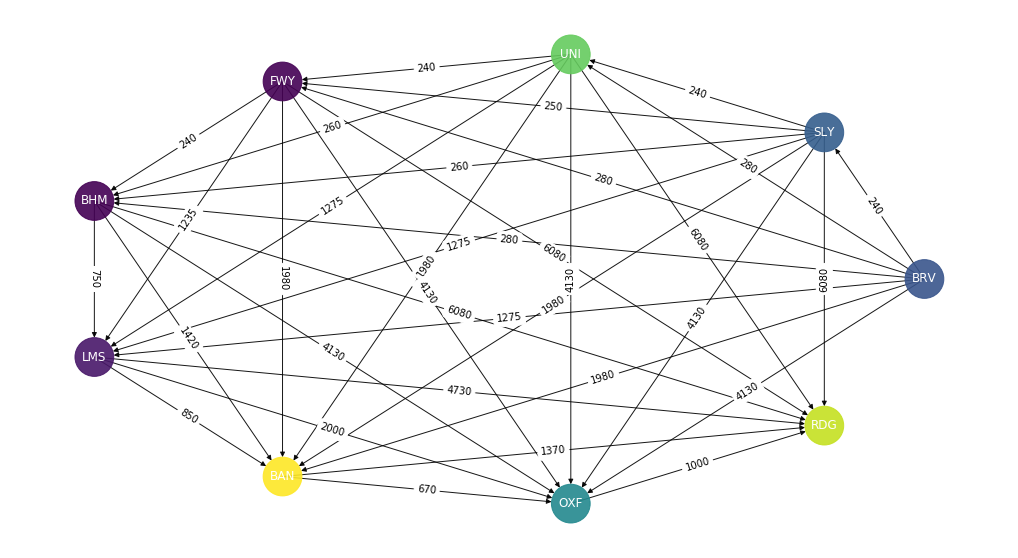

In [67]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
plt.rcParams['figure.figsize'] = [18, 10]
import random

G = nx.DiGraph()
for i in range(0,len(commonStoppingList)-1):
    for faresIndexCounter in range(len(fares[i])):
        G.add_edges_from([(commonStoppingList[i],commonStoppingList[faresIndexCounter+i+1])], weight=fares[i][faresIndexCounter])   

val_map = { i : (random.randint(1,50)) for i in commonStoppingList }        
values = [val_map.get(node, 0.4577) for node in G.nodes()]
# values = [1, 2.6, 3, 4, 5, 6, 7, 8, 9]
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges = []
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]
node_labels = {node:node for node in G.nodes()}; 
pos=nx.circular_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos, labels=node_labels,font_color='white')
nx.draw(G,pos, node_color = values, node_size=1500,edge_color=edge_colors,edge_cmap=plt.cm.Reds,alpha=0.9)

In [68]:
from utils.dijkstra import dijkstra , Graph

Below subroutine of ```findCheapest``` works on the above generated graph network and applies [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization),  to find the cheapest possible route. This is similar to classic [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) 



In [69]:
def findCheapest(commonStoppingList,fares):
    graph = Graph()
    for x in commonStoppingList:
        graph.add_node(x)
    
    for i in range(0,len(commonStoppingList)-1):
        for faresIndexCounter in range(len(fares[i])):
            graph.add_edge(commonStoppingList[i],commonStoppingList[faresIndexCounter+i+1],fares[i][faresIndexCounter])   
    
    result, path = dijkstra(graph, commonStoppingList[0])
    
    node = commonStoppingList[-1]
    nodes = [];
    while node:
        nodes.append(node)
        node = path.get(node)
        
    nodes.reverse()
    total = 0
    out = []
    for i in range(0, len(nodes)-1):
        f = nodes[i]
        t = nodes[i+1]
        d = 0
        if(i == 0):
            d = fares[commonStoppingList.index(f)][commonStoppingList.index(t)-1]
        else:
            d = fares[commonStoppingList.index(f)][commonStoppingList.index(t)-commonStoppingList.index(f)-1]
        
        out.append( (f,t) )
        total += d
#         print("f --",f , " t---",t , "dist --",d)
    return out, total

In [70]:
cheapestPath , cheapestFare = findCheapest(commonStoppingList,fares) # find chepeast Fare and Cheapest Path
print("Cheapest Fare " , cheapestFare)


Cheapest Fare  3070


Cheapest Fare is **£30.70**. Note the original fare for first service was **£57.20**

In [71]:
print("Cheapest Routes ")
for i in cheapestPath:
    print(i[0],"---->",i[1])
      

Cheapest Routes 
BRV ----> BHM
BHM ----> BAN
BAN ----> RDG


Above is the breakdown of the route for the cheapest ticket. It is more clearly visible in graph below. The cheapest route is marked in **red**.

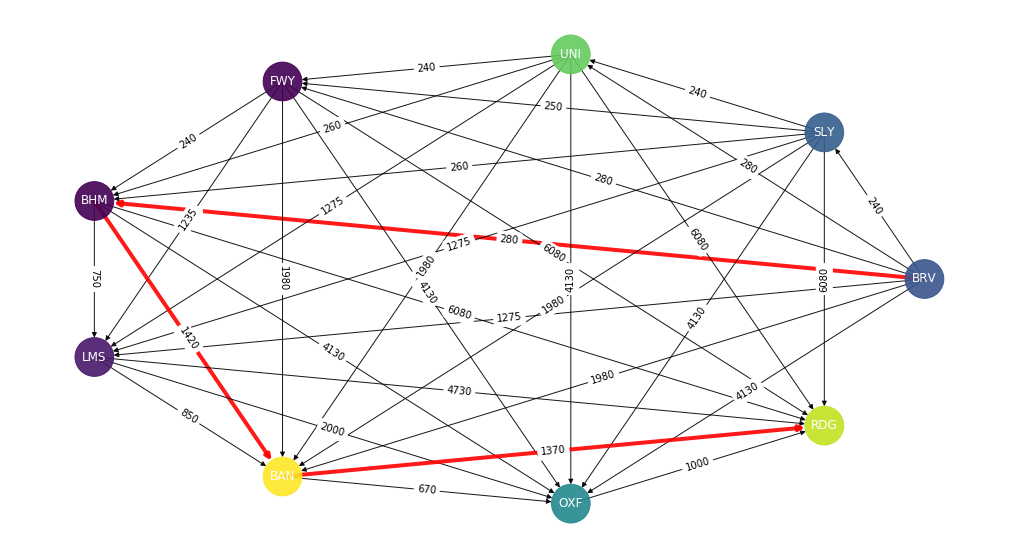

In [72]:
red_edges = cheapestPath

edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]
edge_width =  [1 if not edge in red_edges else 4 for edge in G.edges()]
node_labels = {node:node for node in G.nodes()};
pos=nx.circular_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos, labels=node_labels,font_color='white')
nx.draw(G,pos, node_color = values, node_size=1500,edge_color=edge_colors,edge_cmap=plt.cm.Reds,alpha=0.9,width=edge_width)